In [6]:
import arviz as az
import pymc3 as pm
import numpy as np
import warnings
import emcee
from corner import corner
from pathlib import Path
import pandas as pd

from data import dataloader
from models.model import Model
import matplotlib.pyplot as plt
from scipy import stats as st

# warnings.filterwarnings("ignore", category=RuntimeWarning, module="emcee")
warnings.filterwarnings("ignore", module="corner")
warnings.filterwarnings("ignore", category=UserWarning, module="arviz")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="arviz")

In [10]:
class Results:
    
    def __init__(self, fpath):
        self.fpath = Path(fpath)
        self.hdf = emcee.backends.HDFBackend(str(self.fpath))
        
        with self.hdf.open("r") as f:
            self.labels = list(f["parameter_names"].asstr())
            
        self.trace = az.from_emcee(self.hdf, var_names=self.labels)
  
    def summarize_results(self):
        smart_burn = 50 * self.hdf.get_autocorr_time().mean()
        if 0 < smart_burn < 10000:
            burn = smart_burn
        else:
            burn = 5000
        trace_burn = self.trace.sel(draw=slice(burn, None))
        
        # Corner Plot
        fig = corner(trace_burn, show_titles=True)
        savefile = Path(f"figures/{self.fpath.relative_to('results/')}_corner.pdf" )
        savefile.parent.mkdir(exist_ok=True)
        fig.savefig(savefile);
        plt.close()
        
        summary_df = trace_burn.posterior.to_dataframe().reset_index().describe(percentiles=[])
        return summary_df

In [11]:
for path in Path("results/zpeg/").glob("*.hd5"):
    r = Results(path)
    display(r.summarize_results())

,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,136248.000000,136248.000000,136248.000000,136248.000000,136248.000000,136248.000000,136248.000000,136248.000000,1.362480e+05
mean,11.500000,7161.000000,0.159871,0.282939,-0.117824,2.644842,-19.126732,9.478186,3.971157e-02
std,6.922212,1638.814728,0.005355,0.022566,0.007302,0.082384,0.026120,0.705531,2.461668e-02
min,0.000000,4323.000000,0.141346,0.250004,-0.144940,2.286520,-19.216322,6.290940,9.566252e-09
50%,11.500000,7161.000000,0.159777,0.279161,-0.117793,2.645284,-19.124410,9.490403,3.751471e-02
max,23.000000,9999.000000,0.183528,0.349890,-0.079064,2.975578,-19.052489,14.178827,9.999048e-02


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,129552.000000,129552.000000,129552.000000,129552.000000,129552.000000,129552.000000,129552.000000,129552.000000,129552.000000
mean,11.500000,7300.500000,0.160176,0.284323,-0.117183,2.642549,-19.116719,9.753538,0.030340
std,6.922213,1558.274364,0.005346,0.022973,0.007656,0.080477,0.025615,0.994092,0.023138
min,0.000000,4602.000000,0.138771,0.250011,-0.148870,2.293208,-19.215933,5.994082,0.000001
50%,11.500000,7300.500000,0.160094,0.281215,-0.117257,2.641816,-19.111521,9.790443,0.024621
max,23.000000,9999.000000,0.183251,0.349987,-0.086944,2.977068,-19.051373,15.096317,0.099993


/home/keto/Projects/research_playground/hubble_constant_mass_correction/.venv/lib/python3.8/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,11.500000,7499.500000,5.556031,0.305715,0.484757,3.008657,-18.947657,9.597224,0.045235
std,6.922215,1443.381658,13.763189,0.026410,0.935329,0.186071,10.308630,0.962227,0.025667
min,0.000000,5000.000000,0.226176,0.252385,-1.365470,2.653524,-43.691948,8.279173,0.005142
50%,11.500000,7499.500000,1.289034,0.310489,0.462010,2.970116,-16.987634,9.305647,0.042668
max,23.000000,9999.000000,68.656073,0.344135,2.186414,3.346637,-0.208345,11.632562,0.091611


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,126720.000000,126720.000000,126720.000000,126720.000000,126720.000000,126720.000000,126720.000000,126720.000000,126720.000000
mean,11.500000,7359.500000,0.160240,0.283685,-0.117868,2.650256,-19.117815,9.721746,0.031109
std,6.922214,1524.210697,0.005349,0.022881,0.007684,0.080968,0.022972,0.868170,0.021219
min,0.000000,4720.000000,0.138962,0.250000,-0.150315,2.267179,-19.221659,6.284275,0.000003
50%,11.500000,7359.500000,0.160057,0.279725,-0.117849,2.650341,-19.114519,9.654982,0.027731
max,23.000000,9999.000000,0.187877,0.349983,-0.086293,2.989351,-19.053744,14.577192,0.099997


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,140952.000000,140952.000000,140952.000000,140952.000000,140952.000000,140952.000000,140952.000000,140952.000000,1.409520e+05
mean,11.500000,7063.000000,0.160093,0.284337,-0.117793,2.651363,-19.114325,9.730180,2.708530e-02
std,6.922211,1695.395055,0.005460,0.022710,0.007506,0.080668,0.023779,1.057615,2.172153e-02
min,0.000000,4127.000000,0.141187,0.250000,-0.147995,2.308809,-19.216497,6.201204,5.121763e-07
50%,11.500000,7063.000000,0.159884,0.280738,-0.117776,2.651804,-19.109940,9.641230,2.163456e-02
max,23.000000,9999.000000,0.186227,0.349966,-0.089322,3.029972,-19.050715,14.938164,9.991416e-02


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,128352.000000,128352.000000,128352.000000,128352.000000,128352.000000,128352.000000,128352.000000,128352.000000,128352.000000
mean,11.500000,7325.500000,0.159848,0.284498,-0.117766,2.648121,-19.117250,9.684591,0.030288
std,6.922214,1543.840607,0.005388,0.022665,0.007589,0.081901,0.023455,0.901870,0.021906
min,0.000000,4652.000000,0.141386,0.250005,-0.149215,2.269522,-19.212416,6.396078,0.000001
50%,11.500000,7325.500000,0.159725,0.281055,-0.117687,2.648077,-19.113494,9.609880,0.025789
max,23.000000,9999.000000,0.184052,0.349991,-0.085598,3.025816,-19.054377,14.359301,0.099973


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,126456.000000,126456.000000,126456.000000,126456.000000,126456.000000,126456.000000,126456.000000,126456.000000,126456.000000
mean,11.500000,7365.000000,0.159682,0.283386,-0.117733,2.648164,-19.117794,9.644013,0.030690
std,6.922214,1521.035271,0.005345,0.022195,0.007543,0.081452,0.023852,0.889994,0.022224
min,0.000000,4731.000000,0.139698,0.250002,-0.149649,2.286644,-19.217842,6.347218,0.000004
50%,11.500000,7365.000000,0.159534,0.279915,-0.117723,2.648830,-19.114085,9.586003,0.026220
max,23.000000,9999.000000,0.185296,0.349998,-0.086607,2.966743,-19.052471,14.284241,0.099906


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,127104.000000,127104.0000,127104.000000,127104.000000,127104.000000,127104.000000,127104.000000,127104.000000,127104.000000
mean,11.500000,7351.5000,0.160097,0.283390,-0.117960,2.646633,-19.116386,9.726880,0.029548
std,6.922214,1528.8295,0.005535,0.022621,0.007602,0.079255,0.022895,0.919368,0.021234
min,0.000000,4704.0000,0.139473,0.250001,-0.149516,2.293066,-19.212741,5.888766,0.000005
50%,11.500000,7351.5000,0.159967,0.280068,-0.118030,2.646948,-19.113079,9.616658,0.025208
max,23.000000,9999.0000,0.184540,0.349947,-0.087903,2.984311,-19.054760,14.250538,0.099958


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,141600.000000,141600.000000,141600.000000,141600.000000,141600.000000,141600.000000,141600.000000,141600.000000,141600.000000
mean,11.500000,7049.500000,0.160012,0.283938,-0.117845,2.646225,-19.118642,9.734300,0.031742
std,6.922211,1703.189284,0.005416,0.022616,0.007331,0.081994,0.023919,0.867693,0.022273
min,0.000000,4100.000000,0.139449,0.250001,-0.148960,2.258719,-19.212181,6.244212,0.000005
50%,11.500000,7049.500000,0.159861,0.280667,-0.117838,2.645515,-19.115320,9.648686,0.027685
max,23.000000,9999.000000,0.187285,0.349955,-0.085564,3.023675,-19.053730,15.022491,0.099952


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,136224.000000,136224.000000,136224.000000,136224.000000,136224.000000,136224.000000,136224.000000,136224.000000,1.362240e+05
mean,11.500000,7161.500000,0.159904,0.284164,-0.117663,2.644547,-19.116521,9.713192,2.994936e-02
std,6.922212,1638.526053,0.005380,0.022528,0.007528,0.080696,0.022777,0.858788,2.104274e-02
min,0.000000,4324.000000,0.139113,0.250000,-0.150186,2.298684,-19.208628,6.361124,2.532711e-07
50%,11.500000,7161.500000,0.159692,0.281132,-0.117676,2.643353,-19.113840,9.642841,2.596595e-02
max,23.000000,9999.000000,0.185388,0.349985,-0.085534,2.970994,-19.048748,14.620282,9.997806e-02


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,126576.000000,126576.000000,126576.000000,126576.000000,126576.000000,126576.000000,126576.000000,126576.000000,126576.000000
mean,11.500000,7362.500000,0.159832,0.282762,-0.117768,2.646826,-19.123117,9.509602,0.035623
std,6.922214,1522.478647,0.005476,0.022115,0.007241,0.082900,0.024912,0.721269,0.023796
min,0.000000,4726.000000,0.140459,0.250005,-0.147656,2.318249,-19.213028,6.149387,0.000001
50%,11.500000,7362.500000,0.159612,0.279464,-0.117791,2.646249,-19.120782,9.478409,0.032471
max,23.000000,9999.000000,0.185586,0.349959,-0.082670,2.982485,-19.053510,14.229852,0.099972


,chain,draw,sigma_int,Om0,alpha,beta,M_B,loc,size
count,129528.000000,129528.000000,129528.000000,129528.000000,129528.000000,129528.000000,129528.000000,129528.000000,1.295280e+05
mean,11.500000,7301.000000,0.159463,0.284187,-0.117579,2.648474,-19.128337,9.488188,4.253012e-02
std,6.922213,1557.985689,0.005350,0.022509,0.007397,0.082448,0.025509,0.632347,2.491249e-02
min,0.000000,4603.000000,0.138490,0.250001,-0.151641,2.298989,-19.216838,6.663745,5.650777e-07
50%,11.500000,7301.000000,0.159244,0.281074,-0.117605,2.648766,-19.126873,9.473081,4.099524e-02
max,23.000000,9999.000000,0.186329,0.349959,-0.089092,3.020381,-19.046057,13.929462,9.997993e-02


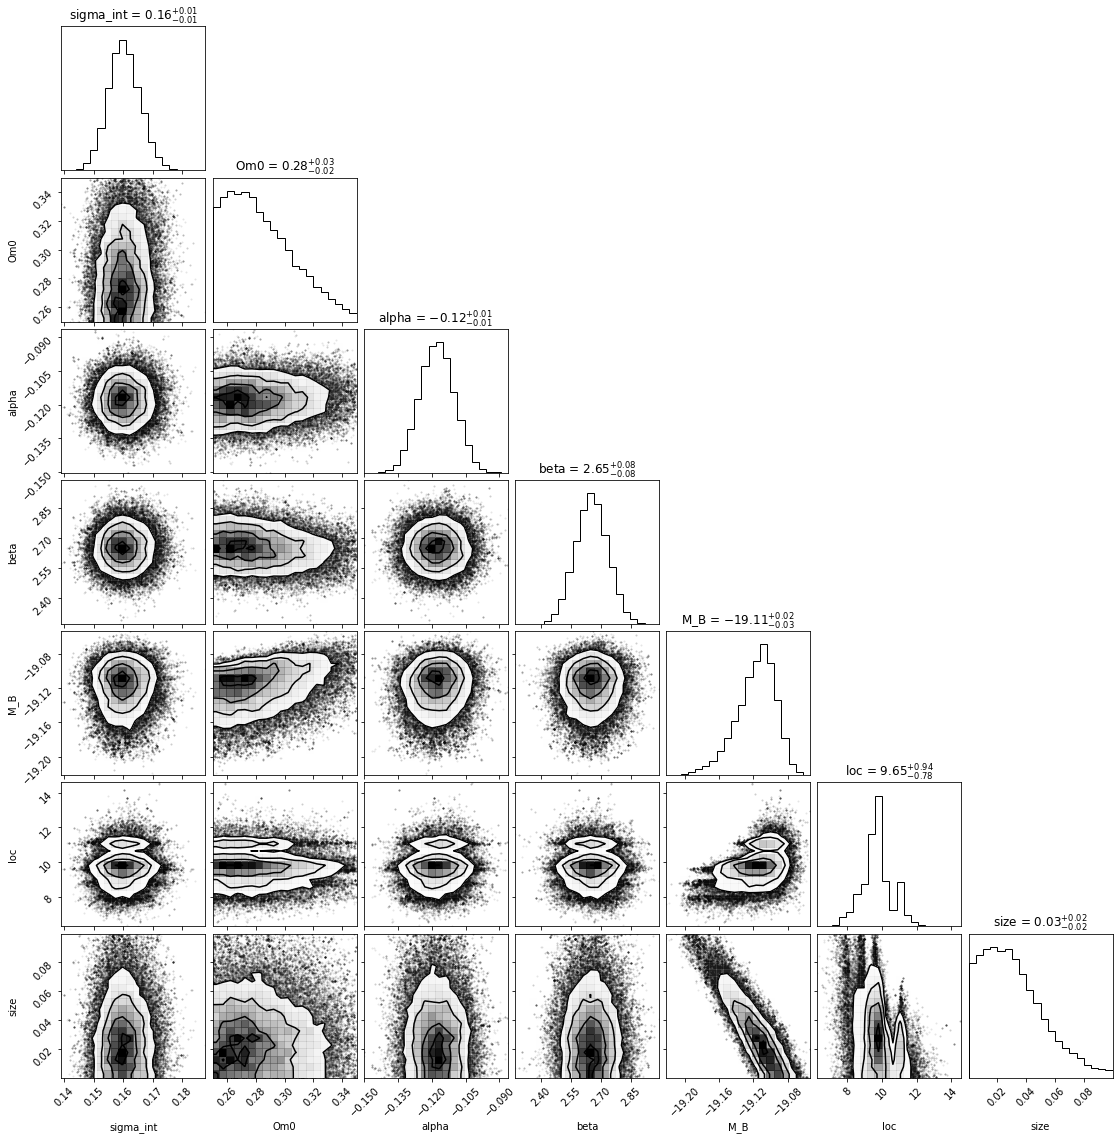

In [7]:


az.plot_trace(trace);
fig = corner(trace_burn, show_titles=True)
fig.savefig('figures/corner.pdf');

# az.plot_pair(trace_burn, kind=["scatter", "kde"], marginals=True, figsize=(20, 20));
# az.plot_posterior(trace_burn, figsize=(12, 12), hdi_prob=0.64);
# az.plot_forest(trace_burn, combined=True, figsize=(8, 12))